In [1]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [2]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col = ["year"])
data.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

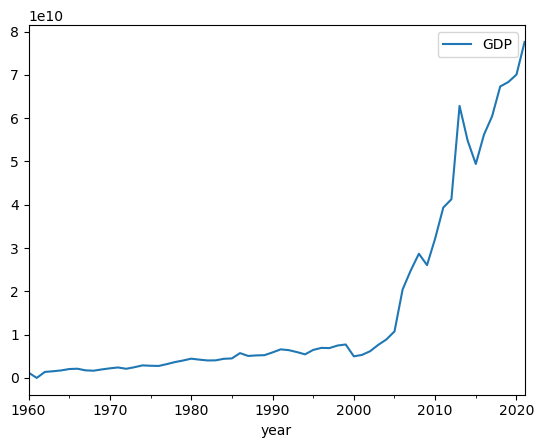

In [3]:
data.plot()

In [4]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

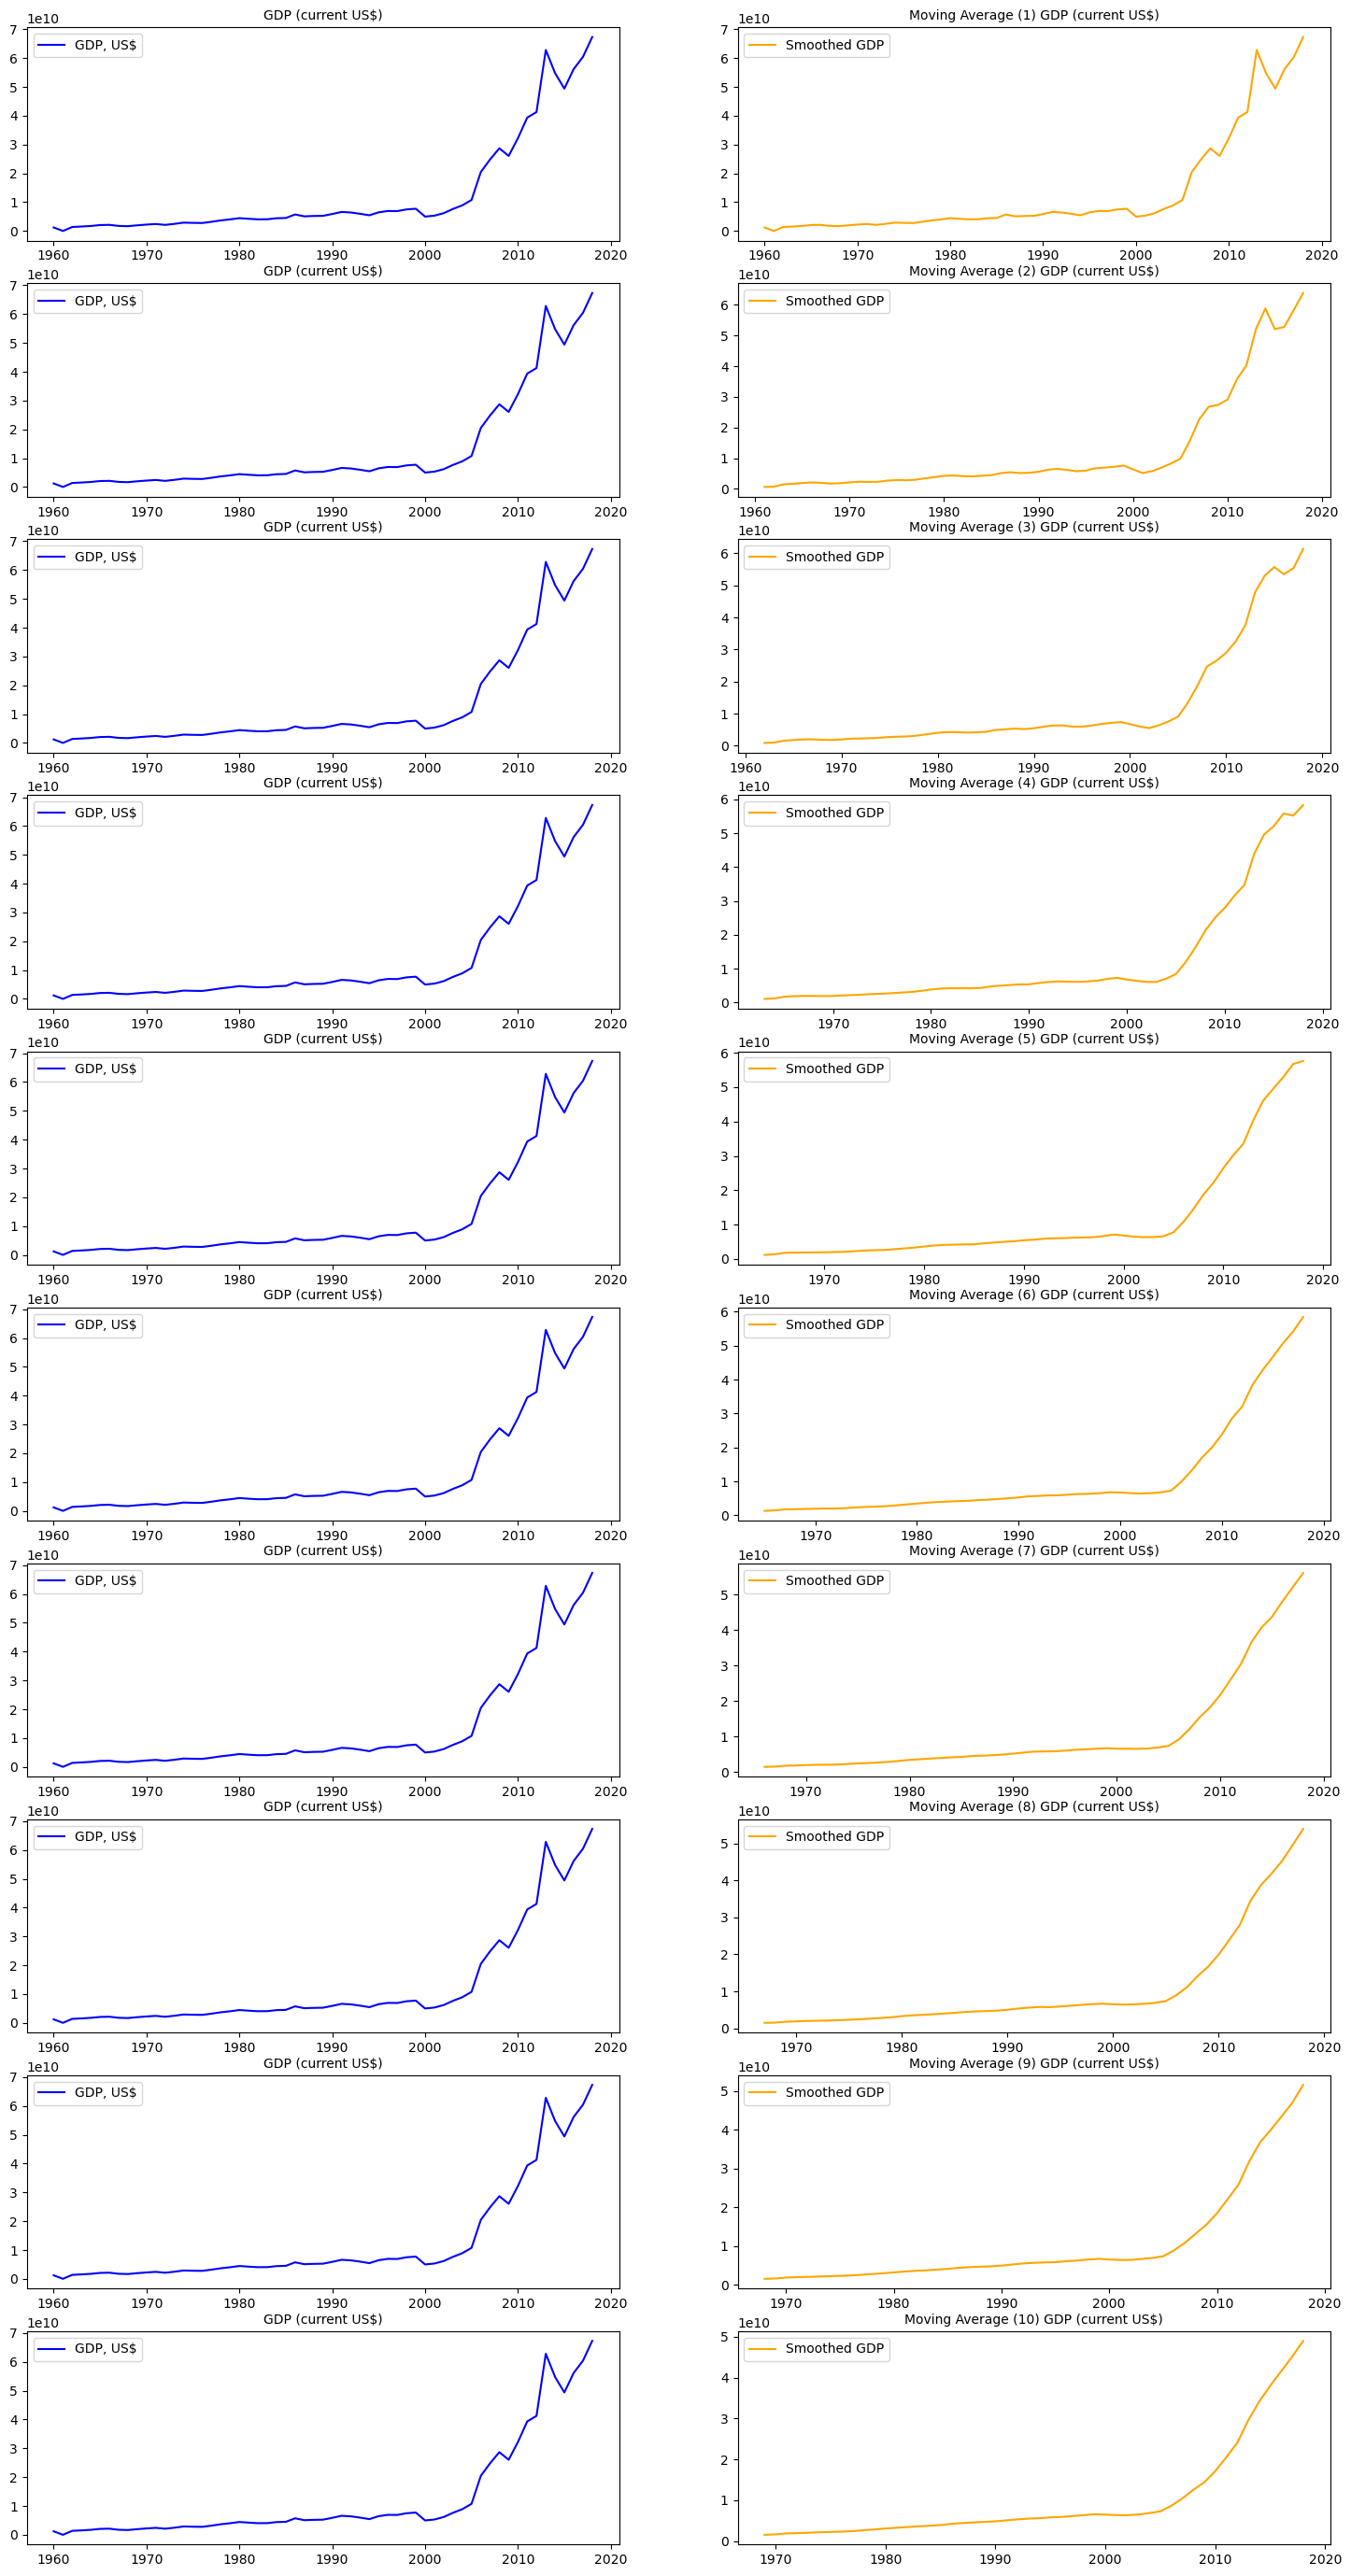

In [5]:
plt.rcParams["figure.figsize"] = 18, 35

N_windows = 10
delta_N = 1

fig, ax = plt.subplots(N_windows, 2)

figure_index = 0
for window in np.arange(0 + delta_N, (N_windows + 1) * delta_N, delta_N):
    ax[figure_index, 0].plot(train_df.GDP, color="blue", label="GDP, US$")
    ax[figure_index, 0].set_title("GDP (current US$)", size=10)
    ax[figure_index, 0].legend()

    ax[figure_index, 1].plot(train_df.GDP.rolling(window=window).mean(),
                             color="orange", label="Smoothed GDP")
    ax[figure_index, 1].set_title(
        f"Moving Average ({window}) GDP (current US$)", size=10)
    ax[figure_index, 1].legend()

    figure_index = figure_index + 1


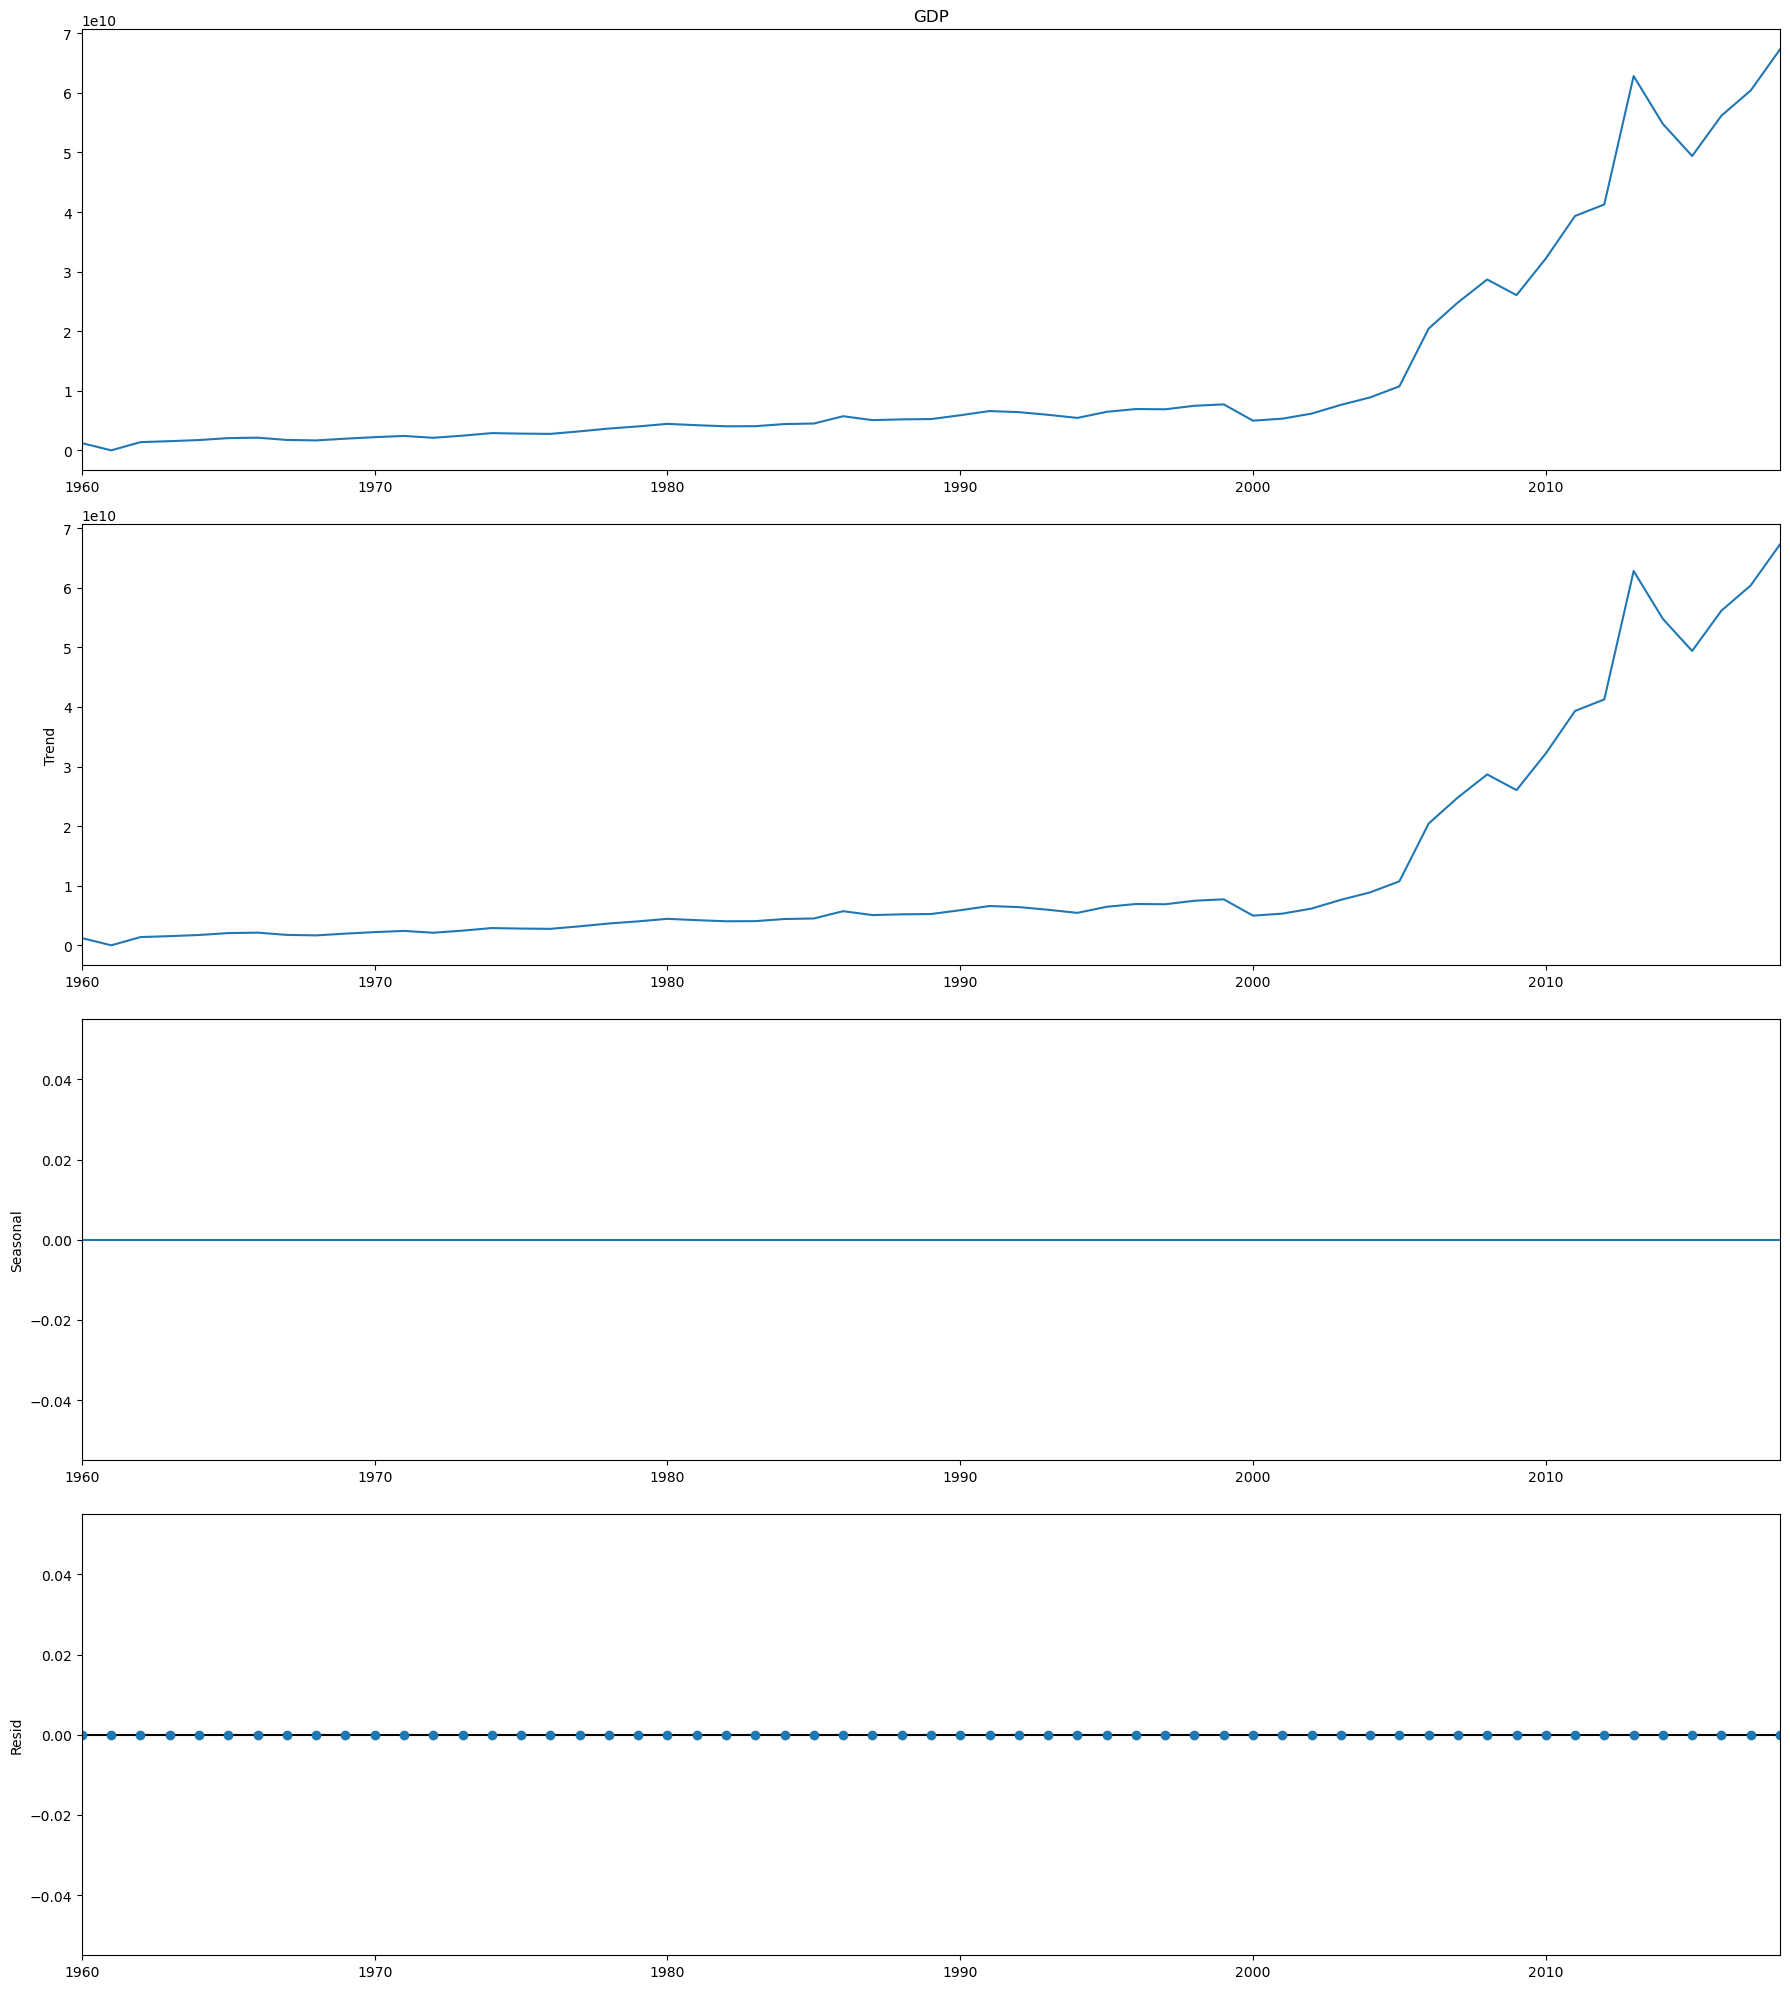

In [6]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.GDP, model='additive')
result.plot()
plt.show()

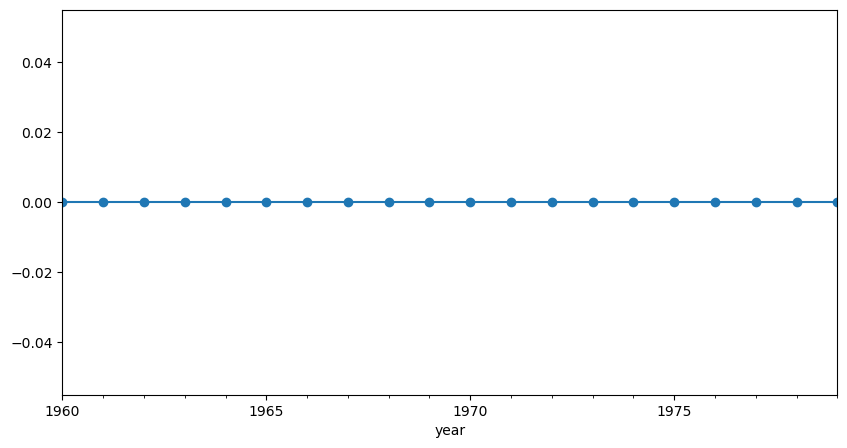

In [7]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "o")
plt.show()

Визуально сезонность полностью отсутствует.

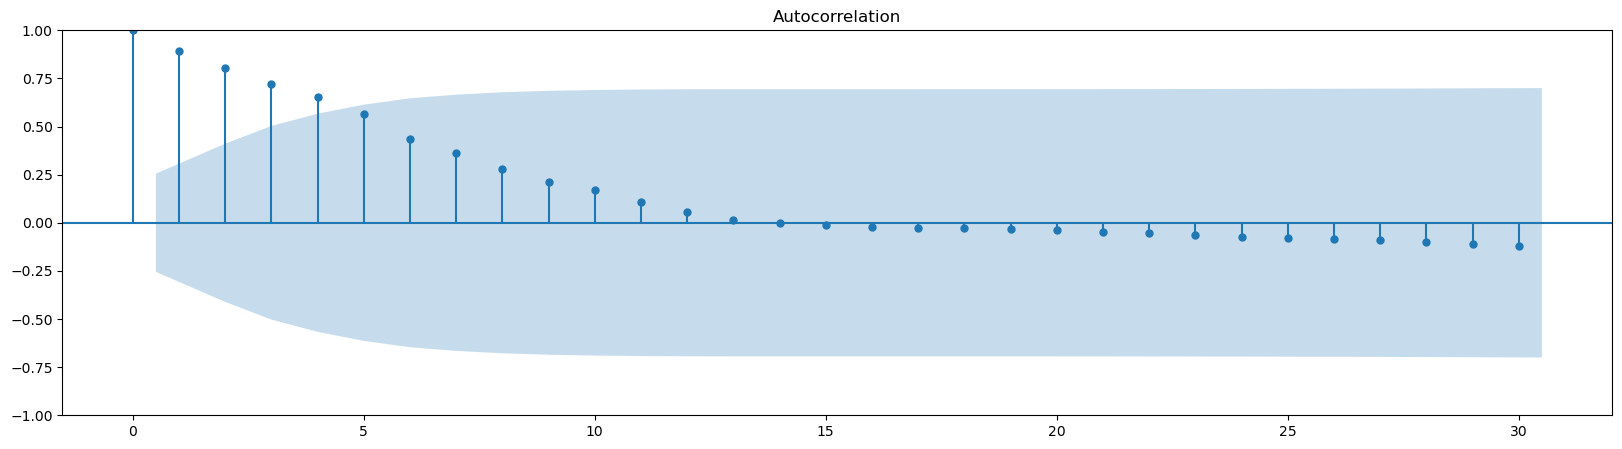

In [8]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.GDP, zero=True, lags=30)
plt.show()


Корреляция сохраняется спустя 3-4 года.
Положим q = 3.

In [9]:
q = 3

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


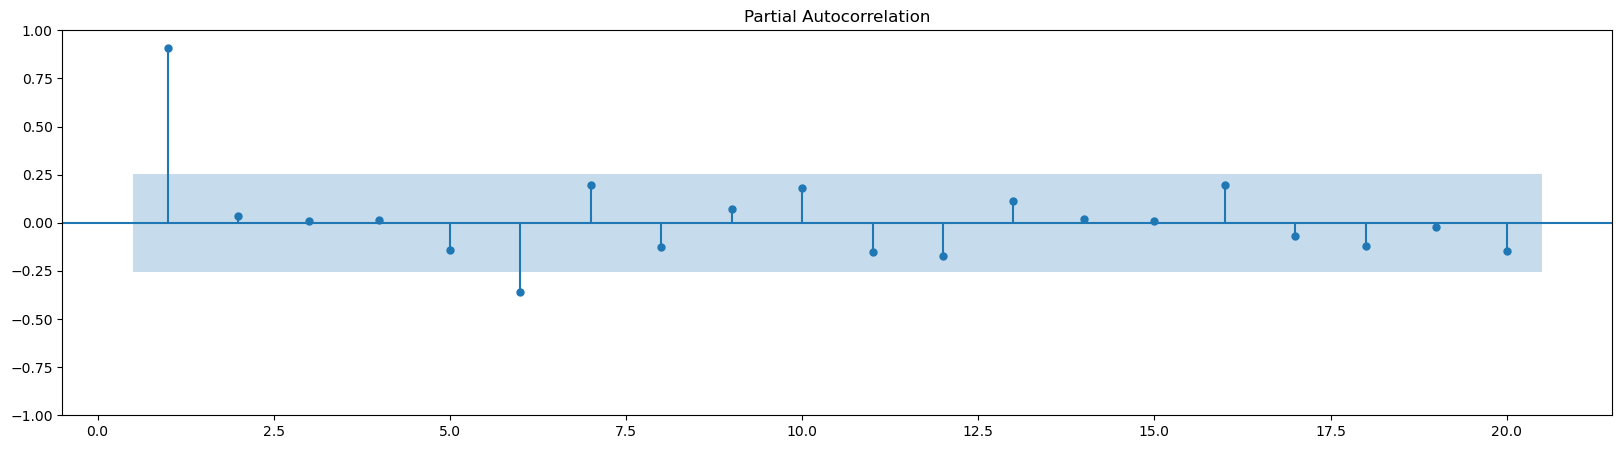

In [10]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.GDP, zero = False, lags = 20)
plt.show()

Порядок возможной авторегрессионной модели - 1 (p = 1).

In [11]:
p = 1

In [12]:
test_adfuller = adfuller(train_df.GDP)

display(test_adfuller)

print('adf: ', test_adfuller[0])
print('p-value: ', test_adfuller[1])
print('Critical values: ', test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')


(0.6529066974885368,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

adf:  0.6529066974885368
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


Отвергаем $H_0$ в тесте Дики-Фуллера. Ряд нестационарен.

In [13]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, lags=30, ax=axes[0])
    sgt.plot_pacf(series, lags=20, ax=axes[1])
    plt.show()


/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


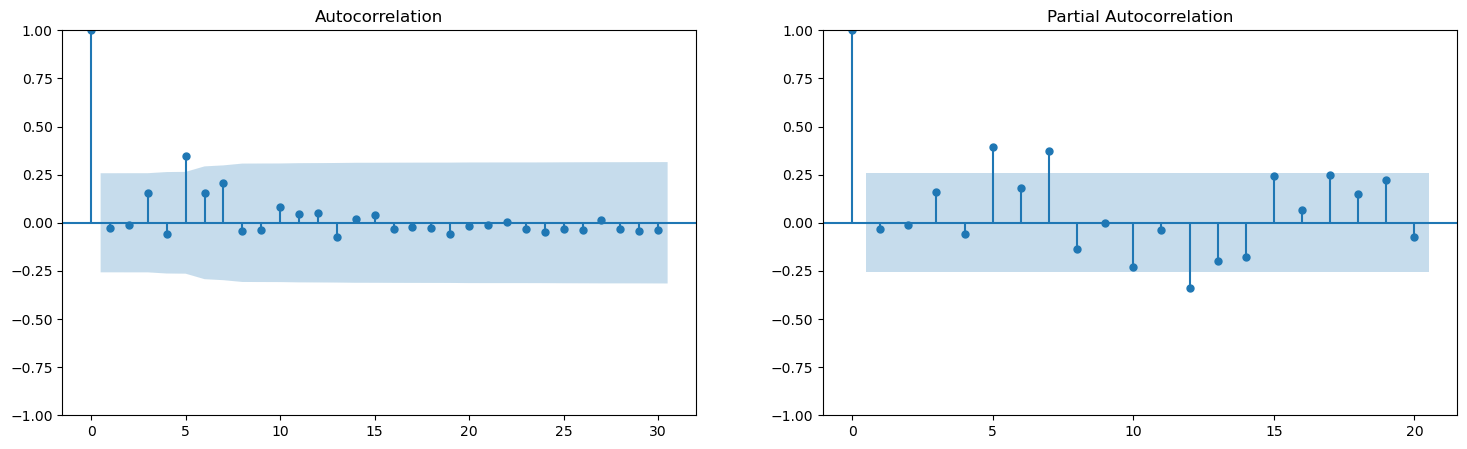

(-1.6702483038320775,
 0.4465029329713892,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [14]:
# Дифференцирование ряда первого порядка
train_df_d1 = train_df['GDP'].diff(1).dropna()
plot_acf_pacf(train_df_d1)
adfuller(train_df_d1)

Некоторые корреляции немного выбиваются за пределы доверительных интервалов.
Ряд почти стационарный. Но попробуем ещё раз его продифференцировать.

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


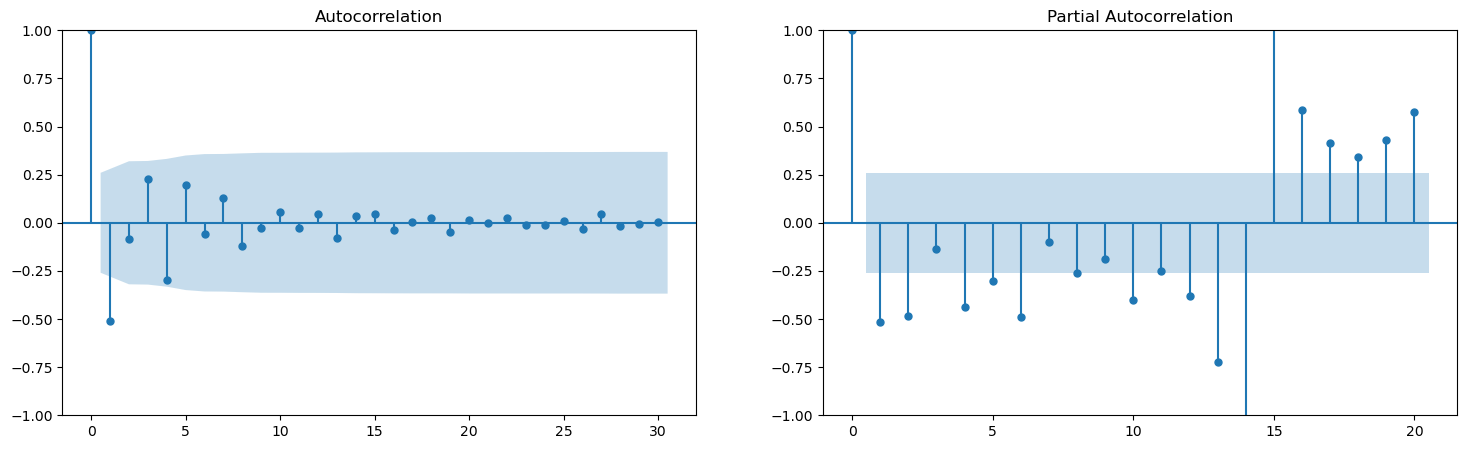

(-2.640869056128477,
 0.0848411691783792,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [15]:
# Дифференцирование ряда второго порядка через разделённую разность
# (https://en.wikipedia.org/wiki/Finite_difference)
h = 1
train_df_d2 = (train_df['GDP'] - 2 * train_df['GDP'].shift(h) + train_df['GDP'].shift(2 * h)).dropna() / h**2
plot_acf_pacf(train_df_d2)
display(adfuller(train_df_d2))

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


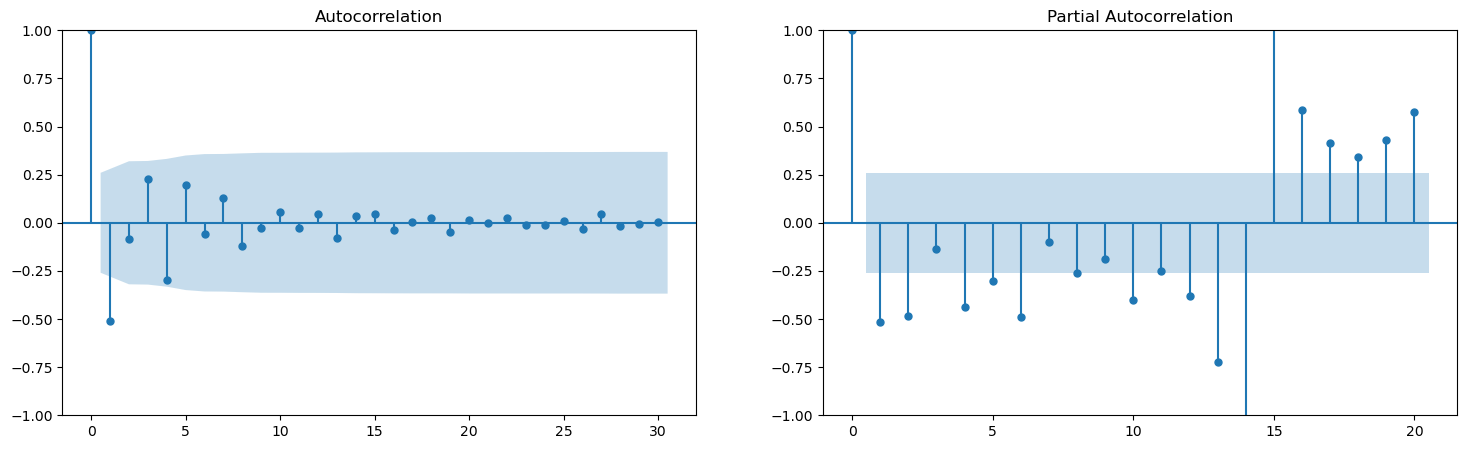

(-2.6408690561284796,
 0.0848411691783787,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [16]:
# Дифференцирование ряда второго порядка через pandas.Series.diff()
train_df_d2 = train_df['GDP'].diff().diff().dropna()
plot_acf_pacf(train_df_d2)
display(adfuller(train_df_d2))

Видны значительные частичные автокорреляции с высокими лагами. Надо скорее всего подбирать автоматически параметры авторегрессионных моделей по такой не очень очевидной картине.

Но пока d = 1 по кореллограммам проидводной первого порядка ряда.

In [17]:
d = 1

In [18]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(train_df['GDP'].dropna(), order = (p, 0, q))
arma_model_fit = arma_model.fit()
arma_model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1392.022
Date:                Mon, 14 Nov 2022   AIC                           2796.044
Time:                        19:07:08   BIC                           2808.509
Sample:                    01-01-1960   HQIC                          2800.910
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.295e+10    1.5e-12   8.63e+21      0.000     1.3e+10     1.3e+10
ar.L1          0.8147      0.048     16.861      0.000       0.720       0.909
ma.L1          0.8043      0.160      5.023      0.000       0.490       1.118
ma.L2          0.7299      0.085      8.593      0.000       0.563       0.896
ma.L3          0.9085      0.108      8.450      0.000       0.698       1.119
sigma2      1.614e+19   1.45e-20   1.11e+39      0.000    1.61e+19    1.61e+19
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):                66.38
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):              55.58   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+54. Standard errors may be unstable.
"""

In [19]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP'].dropna(), order = (p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1356.763
Date:                Mon, 14 Nov 2022   AIC                           2723.526
Time:                        19:07:08   BIC                           2733.828
Sample:                    01-01-1960   HQIC                          2727.539
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7900      0.109      7.253      0.000       0.577       1.004
ma.L1         -0.9608      0.185     -5.199      0.000      -1.323      -0.599
ma.L2         -0.1871      0.256     -0.731      0.465      -0.689       0.314
ma.L3          0.6075      0.197      3.082      0.002       0.221       0.994
sigma2      1.459e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               302.98
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):             132.73   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.55e+55. Standard errors may be unstable.
"""

У модели ARIMA показатель логарифмического правдоподобия чуть выше и показатель AIC чуть ниже по сравнению с ARMA.
То есть модель ARIMA чуть лучше

In [20]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP'].dropna(), order = (p, 2, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 14 Nov 2022   AIC                           2680.765
Time:                        19:07:08   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

С дважды дифференцированным рядом показатели ещё немного лучше (d = 2).

Используем тогда подбор параметров через `pmdarima`.

In [21]:
# pip install pmdarima
from pmdarima import pipeline
from pmdarima import preprocessing
import pmdarima as pm

In [22]:
pipe = pipeline.Pipeline([
    (
        "model", pm.AutoARIMA(
            start_p=1, d=2, start_q=2,
            max_p=2, max_d=2, max_q=3,
            start_P=0, D=0, start_Q=0,
            max_P=0, max_D=0, max_Q=0,
            seasonal=False,
            test='adf',
            stepwise=True,
            trace=True,
            max_iter=100,
            error_action='ignore', suppress_warnings=True
        )
    )
])

pipe.fit(train_df)
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.079, Time=0.01 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 14 Nov 2022   AIC                           2680.765
Time:                        19:07:09   BIC                           2690.980
Sample:                             0   HQIC                          2684.735
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

Пришлось поставить d и max_d равными 2, чтобы получить получше результаты.

Итого пока что лучшая модель - это ARIMA(p=1, d=2, q=3) без интерцепта.

In [23]:
p = 1
d = 2
q = 3

In [24]:
from statsmodels.tsa.arima.model import ARIMA

best_arima_model = ARIMA(train_df['GDP'].dropna(), order = (p, d, q))
best_arima_model = best_arima_model.fit()
best_arima_model.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 14 Nov 2022   AIC                           2680.765
Time:                        19:07:09   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+54. Standard errors may be unstable.
"""

In [25]:
pred_df = pd.DataFrame(index=data.index)
pred_df['model_predictions'] = best_arima_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df['GDP'] = data['GDP']

forecast = best_arima_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

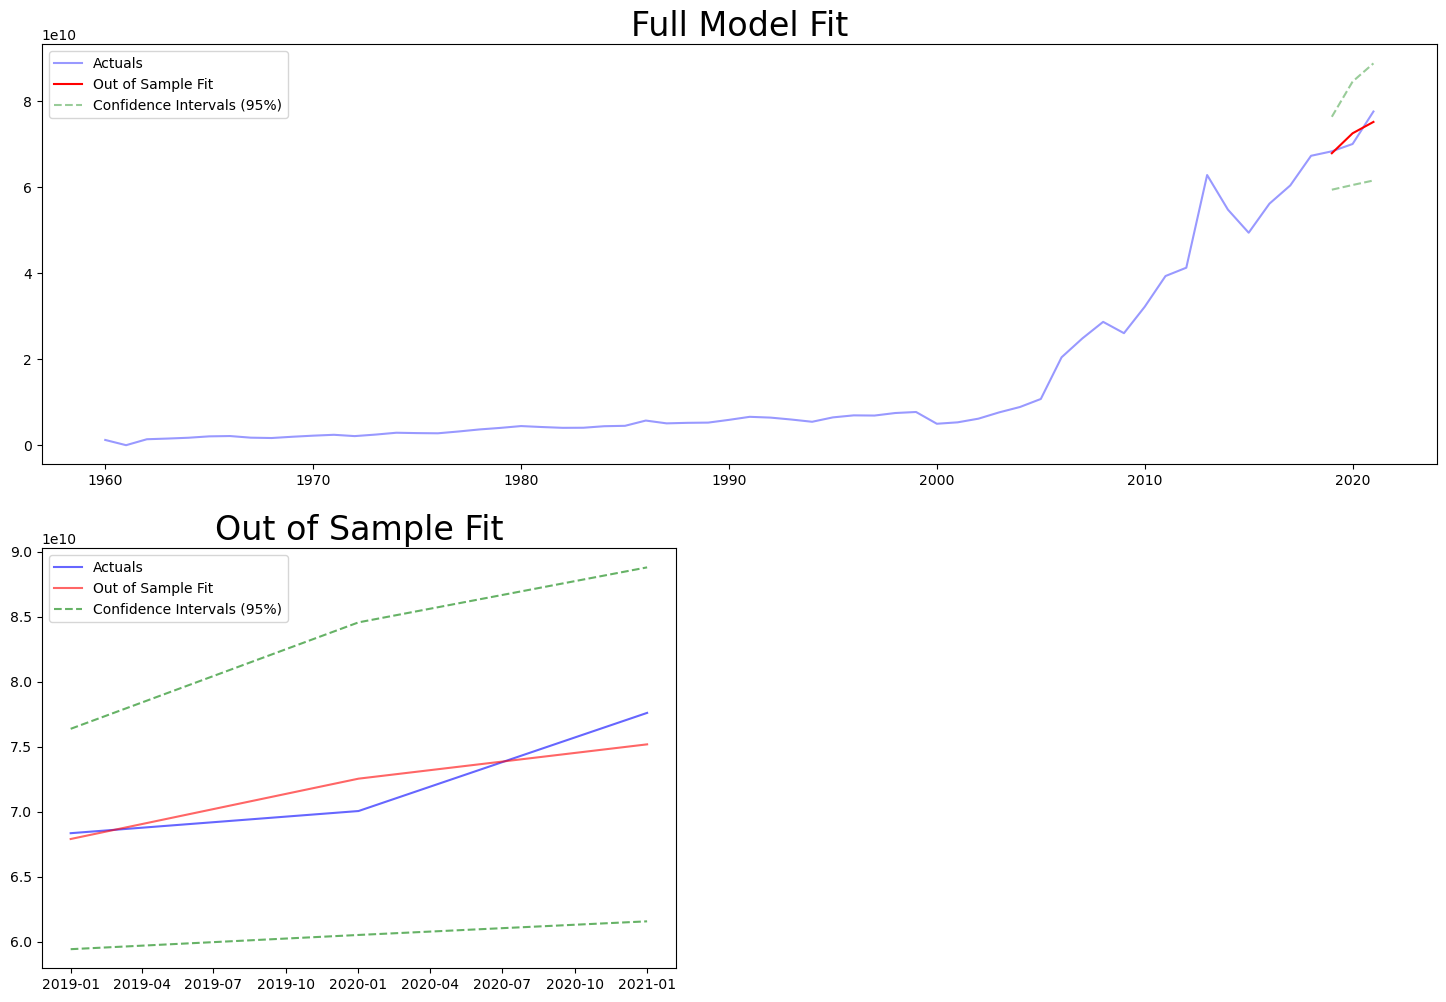

In [26]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP'], color="blue", label="Actuals", alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_predictions"],
         color="red", linestyle="-", label="Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green",
         linestyle="--", label="Confidence Intervals (95%)", alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],
         color="green", linestyle="--", alpha=0.4)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]['GDP'],
         color="blue", label="Actuals", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_predictions"], color="red",
         linestyle="-", label="Out of Sample Fit", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green",
         linestyle="--", label="Confidence Intervals (95%)", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],
         color="green", linestyle="--", alpha=0.6)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()


Модель ARIMA(p=1, d=2, q=3) может предсказывать GDP Ганы по крайней мере на три года вперёд с уровнем доверия 95%.

### Upsampling/Downsampling

<AxesSubplot:xlabel='year'>

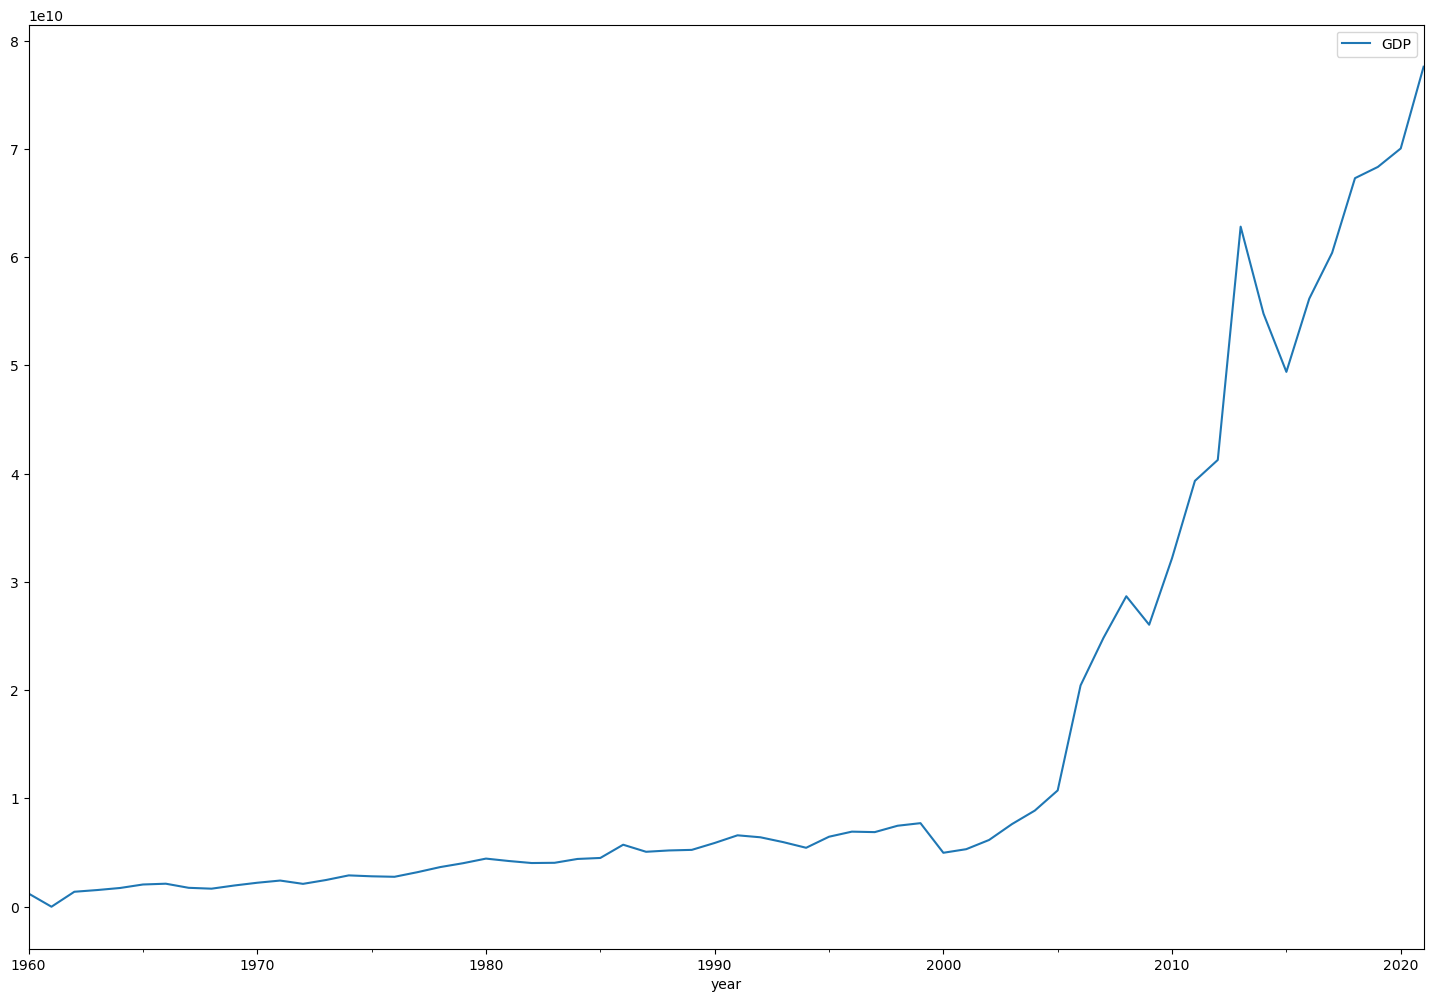

In [27]:
data.plot()

In [30]:
data.GDP.head(10)

year
1960-01-01    1.217087e+09
1961-01-01    0.000000e+00
1962-01-01    1.382353e+09
1963-01-01    1.540616e+09
1964-01-01    1.731092e+09
1965-01-01    2.053221e+09
1966-01-01    2.126050e+09
1967-01-01    1.746806e+09
1968-01-01    1.666910e+09
1969-01-01    1.962051e+09
Name: GDP, dtype: float64

In [35]:
print(data.index.min())
print(data.index.max())

1960-01-01 00:00:00
2021-01-01 00:00:00


In [41]:
print(data.GDP.asfreq(freq='AS').isna().sum())
# print(pd.date_range(start='1960-01-01', end='2021-01-01').difference(data.index))
print(data.reindex(pd.date_range('1960-01-01', '2021-01-01', freq='AS')).isnull().all(1))
print(data.reindex(pd.date_range('1960-01-01', '2021-01-01', freq='AS')).isnull().all(1).sum())


0
1960-01-01    False
1961-01-01    False
1962-01-01    False
1963-01-01    False
1964-01-01    False
              ...  
2017-01-01    False
2018-01-01    False
2019-01-01    False
2020-01-01    False
2021-01-01    False
Freq: AS-JAN, Length: 62, dtype: bool
0


In [42]:
data_gdp = data['GDP'].apply(lambda x: np.nan if x==0 else x)
data_gdp.isna().sum()

1

In [45]:
data_gdp[data_gdp.isna()]

year
1961-01-01   NaN
Name: GDP, dtype: float64

In [46]:
data['GDP'] = data_gdp
data['GDP'].interpolate(method='linear', inplace=True)
data[data['GDP'].isna()]

,GDP
year,


In [47]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [48]:
test_adfuller = adfuller(train_df.GDP)

display(test_adfuller)

print('adf: ', test_adfuller[0])
print('p-value: ', test_adfuller[1])
print('Critical values: ', test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

(0.8030073326980144,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

adf:  0.8030073326980144
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


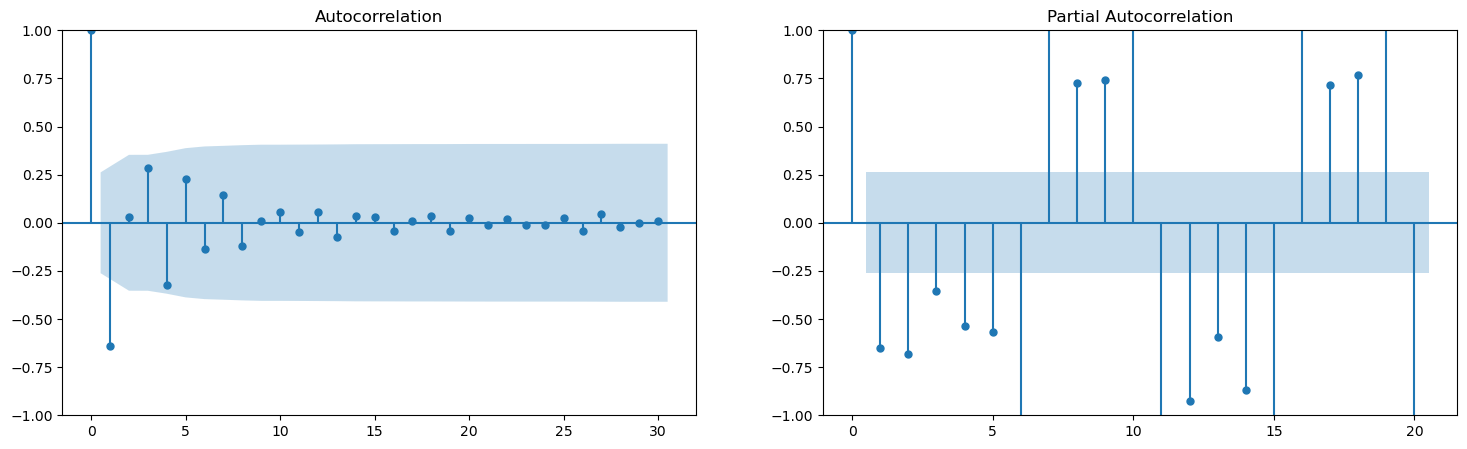

(-4.825603687304037,
 4.857318076799624e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.4811556595264)

adf:  -4.825603687304037
p-value:  4.857318076799624e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд стационарен


In [53]:
# Дифференцирование ряда первого порядка
train_df_d1 = train_df['GDP'].diff(1).diff(1).diff(1).dropna()
plot_acf_pacf(train_df_d1)
test_adfuller = adfuller(train_df_d1)

display(test_adfuller)

print('adf: ', test_adfuller[0])
print('p-value: ', test_adfuller[1])
print('Critical values: ', test_adfuller[4])
if test_adfuller[0] > test_adfuller[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

In [66]:
p = 1
d = 3
q = 3

In [76]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1, stationary=False,
                       test='adf',
                       max_p=3, max_q=3, m=5,
                       start_P=0, seasonal=True,
                       d=0, D=1, max_d=4, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=2627.430, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=2540.430, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=2590.865, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=2642.569, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=2545.737, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=2540.562, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=2541.690, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[5] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=2542.410, Time=0.09 sec
 ARIMA(0,0,0)(1,1,0)[5] intercept   : AIC=2614.039, Time=0.01 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=2542.600, Time=0.04 sec
 ARIMA(1,0,1)(1,1,0)[5] intercept   : AIC=2542.983, Time=0.04 sec
 ARIMA(0,0,1)(1,1,0)[5] intercept   : AIC=2591.345, Time=0.03 sec
 ARIMA(2,0,1)(1,1,0)[5] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   59
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 5)   Log Likelihood               -1266.763
Date:                           Mon, 14 Nov 2022   AIC                           2539.527
Time:                                   20:06:39   BIC                           2545.494
Sample:                                        0   HQIC                          2541.828
                                            - 59                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9843      0.028     35.248      0.000       0.930       1.039
ar.S.L5       -0.5069      0.159     -3.196      0.001      -0.818      -0.196
sigma2      1.619e+19   7.69e-22    2.1e+40      0.000    1.62e+19    1.62e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               373.25
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):             309.90   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+56. Standard errors may be unstable.
"""

In [67]:
from statsmodels.tsa.arima.model import ARIMA

best_arima_model = ARIMA(train_df['GDP'].dropna(), order = (p, d, q))
best_arima_model = best_arima_model.fit()
best_arima_model.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 3, 3)   Log Likelihood               -1327.706
Date:                Mon, 14 Nov 2022   AIC                           2665.413
Time:                        19:59:59   BIC                           2675.539
Sample:                    01-01-1960   HQIC                          2669.339
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7837      0.814     -0.962      0.336      -2.380       0.813
ma.L1         -0.8857      1.257     -0.704      0.481      -3.350       1.579
ma.L2         -0.8905      1.211     -0.735      0.462      -3.264       1.483
ma.L3          0.8278      0.334      2.475      0.013       0.172       1.483
sigma2      4.223e+19   2.18e-20   1.94e+39      0.000    4.22e+19    4.22e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.48   Jarque-Bera (JB):               367.62
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):             523.81   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+55. Standard errors may be unstable.
"""

In [68]:
pred_df = pd.DataFrame(index=data.index)
pred_df['model_predictions'] = best_arima_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df['GDP'] = data['GDP']

forecast = best_arima_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

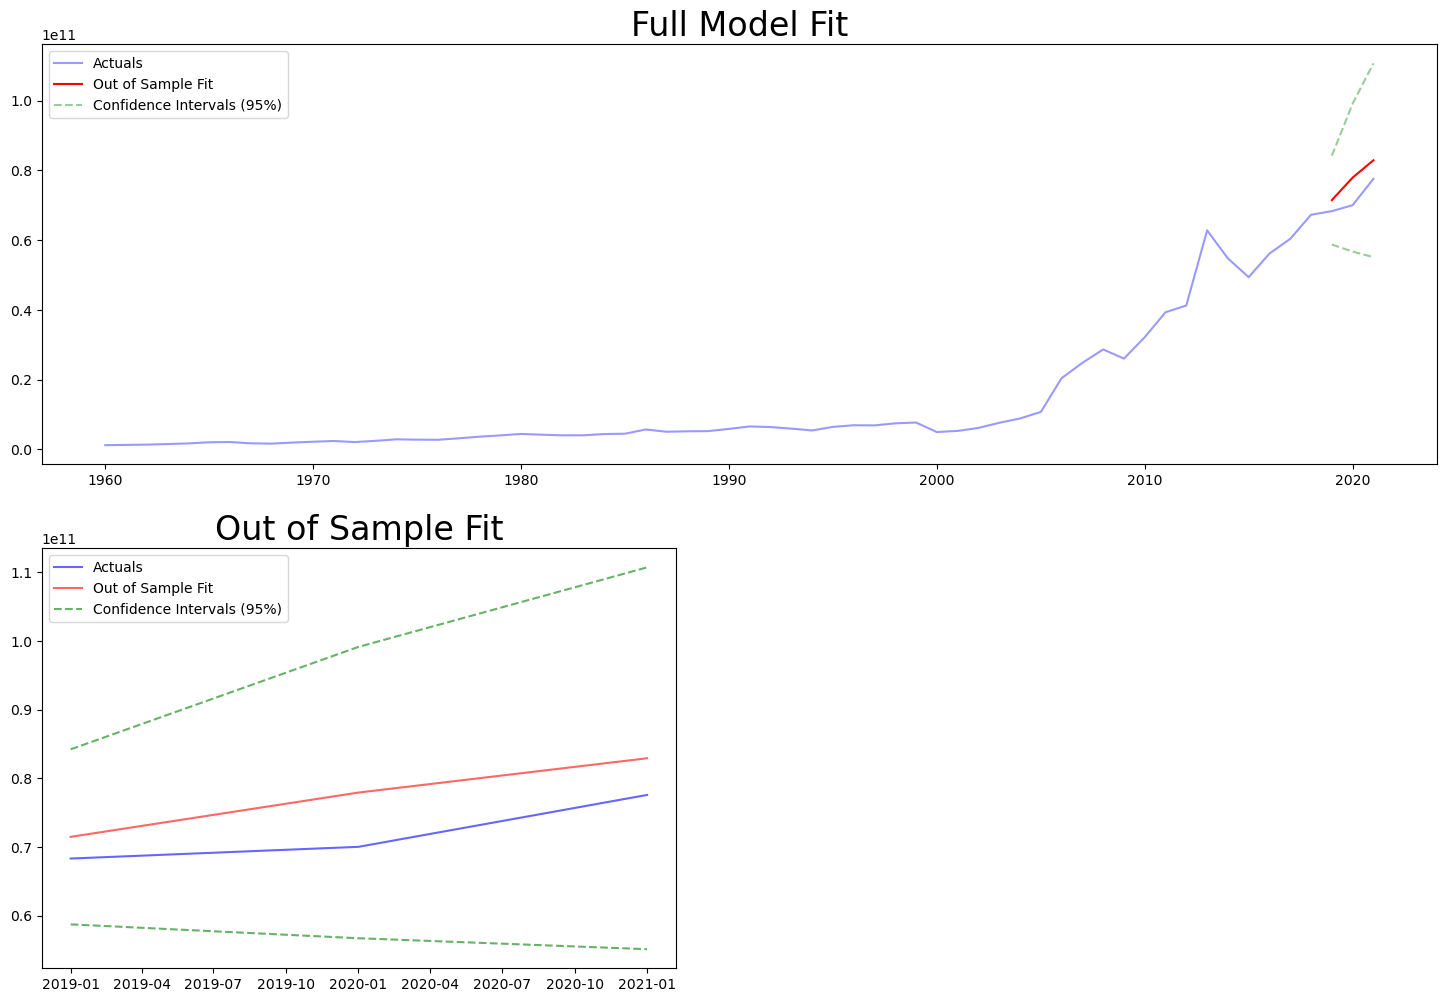

In [69]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP'], color="blue", label="Actuals", alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_predictions"],
         color="red", linestyle="-", label="Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green",
         linestyle="--", label="Confidence Intervals (95%)", alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],
         color="green", linestyle="--", alpha=0.4)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]['GDP'],
         color="blue", label="Actuals", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_predictions"], color="red",
         linestyle="-", label="Out of Sample Fit", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color="green",
         linestyle="--", label="Confidence Intervals (95%)", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],
         color="green", linestyle="--", alpha=0.6)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()


Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [77]:
from sklearn import model_selection

tsplit = model_selection.TimeSeriesSplit(n_splits=3, test_size=7)
for train_index, test_index in tsplit.split(data):
    print('------------------------------')
    print(f"Train length: {len(train_index)}; Test length: {len(test_index)}")

------------------------------
Train length: 41; Test length: 7
------------------------------
Train length: 48; Test length: 7
------------------------------
Train length: 55; Test length: 7
